In [1]:
%load_ext watermark


In [2]:
from IPython.display import display
from backstrip import backplot
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-31T18:46:15.814173+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot: 1.2.0
polars : 1.9.0
seaborn: 0.13.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "perf-wse-vs-gpu-100k"
teeplot_subdir


'perf-wse-vs-gpu-100k'

## Prep Data


In [5]:
cupy_perf = (
    pl.concat(
        [
            pl.read_parquet(
                "https://osf.io/jbqxy/download",
                use_pyarrow=True,
            ).with_columns(
                pl.lit("GPU A100").alias("hardware"),
                pl.lit("denovo counter-based").alias("experiment design"),
                pl.lit(256 * 243 * 243).alias("net population size"),
            ),
        ],
    )
    .filter(pl.col("tile") == 0)
    .with_columns(
        (
            pl.col("net population size") / pl.col("tsc seconds per cycle")
        ).alias("throughput (agent-generations/sec)"),
    )
)
display(cupy_perf)
display(cupy_perf.describe())


tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
u64,f32,f32,f32,f32,u32,u32,u32,u64,u64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u16,u16,str,str,i32,f64
0,13424.635742,0.134246,7.448992,1.34246352e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1260e8
0,13424.725586,0.134247,7.448942,1.34247248e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1260e8
0,13426.507812,0.134265,7.447953,1.34265072e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1259e8
0,13435.211914,0.134352,7.443128,1.34352128e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1251e8
0,13437.150391,0.134372,7.442054,1.34371504e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1250e8
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,13550.757812,0.135508,7.379661,1.35507584e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1155e8
0,13551.762695,0.135518,7.379114,1.35517616e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1155e8
0,13557.875977,0.135579,7.375786,1.35578768e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1150e8


statistic,tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64
"""count""",21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,"""21""","""21""",21.0,21.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0
"""mean""",0.0,13479.355469,0.134794,7.418886,1.34793552e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,1.1215e8
"""std""",0.0,58.689163,0.000587,0.032237,586891.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,487314.016066
"""min""",0.0,13424.635742,0.134246,7.37362,1.34246352e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""GPU A100""","""denovo counter-based""",1.5116544e7,1.1146e8
"""25%""",0.0,13434.679688,0.134347,7.381255,1.343468e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,1.1158e8
"""50%""",0.0,13441.760742,0.134418,7.439502,1.344176e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,1.1246e8
"""75%""",0.0,13547.833008,0.135478,7.443423,1.3547832e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,1.1252e8
"""max""",0.0,13561.860352,0.135619,7.448992,1.35618608e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""GPU A100""","""denovo counter-based""",1.5116544e7,1.1260e8


In [6]:
wse_perf = pl.concat(
    [
        pl.read_parquet(
            "https://osf.io/h3tu4/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("50/50 site-explicit").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
        pl.read_parquet(
            "https://osf.io/w97nx/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("denovo site-explicit").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
        pl.read_parquet(
            "https://osf.io/vh9pb/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("50/50 counter-based").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
        pl.read_parquet(
            "https://osf.io/zp9gt/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("denovo counter-based").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
    ],
).with_columns(
    (pl.col("net population size") / pl.col("tsc seconds per cycle")).alias(
        "throughput (agent-generations/sec)"
    ),
)


In [7]:
df = pl.concat([cupy_perf, wse_perf])
display(df)
display(df.describe())


tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
u64,f32,f32,f32,f32,u32,u32,u32,u64,u64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u16,u16,str,str,i32,f64
0,13424.635742,0.134246,7.448992,1.34246352e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1260e8
0,13424.725586,0.134247,7.448942,1.34247248e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1260e8
0,13426.507812,0.134265,7.447953,1.34265072e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1259e8
0,13435.211914,0.134352,7.443128,1.34352128e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1251e8
0,13437.150391,0.134372,7.442054,1.34371504e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1250e8
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
103685662536,121.983131,0.000244,4098.927246,243966.265625,1000003,4000008,500000,27523,103685690059,1000002,1000002,1000002,1000002,250001,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo counter-based""",190848000,7.8227e11
103659336568,121.952164,0.000244,4099.968262,243904.328125,1000002,4000008,500000,27559,103659364127,1000002,1000002,1000002,1000002,250000,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo counter-based""",190848000,7.8247e11
103683860081,121.98101,0.000244,4098.998535,243962.03125,1000000,4000008,500000,27558,103683887639,1000002,1000002,1000002,1000002,250000,250000,250000,250000,743756,991,506,"""WSE CS-2""","""denovo counter-based""",190848000,7.8229e11


statistic,tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64
"""count""",273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,"""273""","""273""",273.0,273.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0
"""mean""",1.0751e11,1163.357178,0.010622,3449.05542,1.0621702e7,923077.32967,3.6923e6,461538.461538,26886.446886,1.0751e11,923078.769231,923078.769231,923078.769231,923078.769231,230769.377289,230768.882784,230769.556777,230769.512821,686544.0,914.769231,467.076923,null,null,1.7733e8,6.5815e11
"""std""",3.6153e10,3561.953613,0.035912,1120.967773,3.5911536e7,266958.856706,1.0678e6,133479.369497,8127.476264,3.6153e10,266959.272912,266959.272912,266959.272912,266959.272912,66739.727306,66739.584188,66739.779038,66739.766333,198552.16388,264.55611,135.081122,null,null,4.6913e7,2.1424e11
"""min""",0.0,110.615601,0.000221,7.37362,221231.203125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""GPU A100""","""50/50 counter-based""",1.5116544e7,1.1146e8
"""25%""",1.0271e11,121.95208,0.000244,3204.392822,243904.15625,1e6,4.000008e6,500000.0,27523.0,1.0271e11,1.000002e6,1.000002e6,1.000002e6,1.000002e6,250000.0,250000.0,250000.0,250000.0,743756.0,991.0,506.0,null,null,1.90848e8,6.1155e11
"""50%""",1.0389e11,130.341278,0.000261,3836.083252,260682.5625,1.000001e6,4.000008e6,500000.0,28261.0,1.0389e11,1.000002e6,1.000002e6,1.000002e6,1.000002e6,250001.0,250000.0,250000.0,250000.0,743756.0,991.0,506.0,null,null,1.90848e8,7.3211e11
"""75%""",1.2696e11,156.035812,0.000312,4099.971191,312071.625,1.000003e6,4.000008e6,500000.0,28567.0,1.2696e11,1.000002e6,1.000002e6,1.000002e6,1.000002e6,250001.0,250000.0,250001.0,250001.0,743756.0,991.0,506.0,null,null,1.90848e8,7.8247e11
"""max""",1.7584e11,13561.860352,0.135619,4520.158203,1.35618608e8,1.000004e6,4.000008e6,500000.0,35548.0,1.7584e11,1.000002e6,1.000002e6,1.000002e6,1.000002e6,250001.0,250001.0,250001.0,250001.0,743756.0,991.0,506.0,"""WSE CS-2""","""denovo site-explicit""",1.90848e8,8.6266e11


## Absolute performance


/usr/local/lib/python3.10/dist-packages/backstrip/_backplot.py:127: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g = sns.catplot(


teeplots/perf-wse-vs-gpu-100k/col=experiment-design+hue=hardware+orient=h+viz=backplot+x=throughput-agent-generations-sec+ext=.pdf
teeplots/perf-wse-vs-gpu-100k/col=experiment-design+hue=hardware+orient=h+viz=backplot+x=throughput-agent-generations-sec+ext=.png


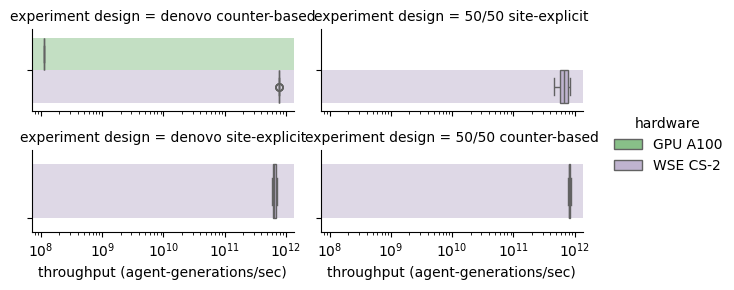

In [8]:
tp.tee(
    backplot,
    data=df.to_pandas(),
    col="experiment design",
    x="throughput (agent-generations/sec)",
    hue="hardware",
    aspect=2,
    col_wrap=2,
    height=1.5,
    orient="h",
    log_scale=(True, False),
    palette=sns.color_palette("Accent"),
    sharey=False,
    teeplot_outexclude="post",
    teeplot_postprocess="""
for ax in teed.axes.flat[2:]:
    ax.set_ylim(-0.1, 0.5)
""",
    teeplot_subdir=teeplot_subdir,
)


In [9]:
df.group_by("hardware", "experiment design",).agg(
    pl.col("throughput (agent-generations/sec)")
    .mean()
    .alias("mean_throughput"),
    pl.col("throughput (agent-generations/sec)").std().alias("std_throughput"),
    pl.col("tsc cycle hertz").mean().alias("mean_speed"),
    pl.col("tsc cycle hertz").std().alias("std_speed"),
)


hardware,experiment design,mean_throughput,std_throughput,mean_speed,std_speed
str,str,f64,f64,f32,f32
"""WSE CS-2""","""50/50 site-explicit""",6.7028e11,1.1047e11,3512.122314,578.845947
"""WSE CS-2""","""denovo site-explicit""",6.5376e11,5.4374e10,3425.558105,284.907532
"""WSE CS-2""","""50/50 counter-based""",8.2192e11,2.9740e10,4306.648438,155.83284
"""WSE CS-2""","""denovo counter-based""",7.8222e11,5.2905e8,4098.675781,2.772118
"""GPU A100""","""denovo counter-based""",1.1215e8,487314.016066,7.418887,0.032237


## Relative Performance


In [10]:
# Step 1: Filter for GPU and calculate the mean throughput per experiment design
gpu_means = (
    df.filter(pl.col("hardware").str.contains("GPU"))
    .group_by("experiment design")
    .agg(pl.mean("throughput (agent-generations/sec)").alias("gpu_mean"))
)
print(gpu_means)

# Step 2: Join the GPU mean back to the original DataFrame
df_with_mean = df.join(gpu_means, on="experiment design", how="left")

# Step 3: Calculate the speedup by dividing throughput by the GPU mean
df_with_speedup = df_with_mean.with_columns(
    (pl.col("throughput (agent-generations/sec)") / pl.col("gpu_mean")).alias(
        "speedup"
    )
)

# Show the resulting DataFrame with speedup
df_with_speedup


shape: (1, 2)
┌──────────────────────┬──────────┐
│ experiment design    ┆ gpu_mean │
│ ---                  ┆ ---      │
│ str                  ┆ f64      │
╞══════════════════════╪══════════╡
│ denovo counter-based ┆ 1.1215e8 │
└──────────────────────┴──────────┘


tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec),gpu_mean,speedup
u64,f32,f32,f32,f32,u32,u32,u32,u64,u64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u16,u16,str,str,i32,f64,f64,f64
0,13424.635742,0.134246,7.448992,1.34246352e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1260e8,1.1215e8,1.004058
0,13424.725586,0.134247,7.448942,1.34247248e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1260e8,1.1215e8,1.004051
0,13426.507812,0.134265,7.447953,1.34265072e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1259e8,1.1215e8,1.003918
0,13435.211914,0.134352,7.443128,1.34352128e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1251e8,1.1215e8,1.003268
0,13437.150391,0.134372,7.442054,1.34371504e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo counter-based""",15116544,1.1250e8,1.1215e8,1.003123
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
103685662536,121.983131,0.000244,4098.927246,243966.265625,1000003,4000008,500000,27523,103685690059,1000002,1000002,1000002,1000002,250001,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo counter-based""",190848000,7.8227e11,1.1215e8,6975.360142
103659336568,121.952164,0.000244,4099.968262,243904.328125,1000002,4000008,500000,27559,103659364127,1000002,1000002,1000002,1000002,250000,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo counter-based""",190848000,7.8247e11,1.1215e8,6977.131763
103683860081,121.98101,0.000244,4098.998535,243962.03125,1000000,4000008,500000,27558,103683887639,1000002,1000002,1000002,1000002,250000,250000,250000,250000,743756,991,506,"""WSE CS-2""","""denovo counter-based""",190848000,7.8229e11,1.1215e8,6975.481218


/usr/local/lib/python3.10/dist-packages/backstrip/_backplot.py:127: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g = sns.catplot(


teeplots/perf-wse-vs-gpu-100k/hue=hardware+orient=h+viz=backplot+x=speedup+y=experiment-design+ext=.pdf
teeplots/perf-wse-vs-gpu-100k/hue=hardware+orient=h+viz=backplot+x=speedup+y=experiment-design+ext=.png


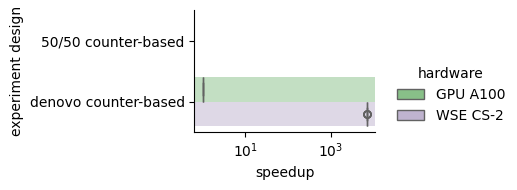

In [11]:
tp.tee(
    backplot,
    data=df_with_speedup.to_pandas(),
    y="experiment design",
    x="speedup",
    hue="hardware",
    aspect=2,
    height=2,
    order=["50/50 counter-based", "denovo counter-based"],
    orient="h",
    log_scale=(True, False),
    palette=sns.color_palette("Accent"),
    teeplot_subdir=teeplot_subdir,
)


In [12]:
df_with_speedup.group_by("hardware", "experiment design",).agg(
    pl.col("speedup").mean().alias("mean_speedup"),
    pl.col("speedup").std().alias("std_speedup"),
)


hardware,experiment design,mean_speedup,std_speedup
str,str,f64,f64
"""WSE CS-2""","""denovo site-explicit""",null,null
"""GPU A100""","""denovo counter-based""",1.0,0.004345
"""WSE CS-2""","""50/50 counter-based""",null,null
"""WSE CS-2""","""50/50 site-explicit""",null,null
"""WSE CS-2""","""denovo counter-based""",6974.933729,4.717457
